### Importing libraries

In [1]:
import jax.numpy as jnp
import numpy as np
from sklearn.datasets import make_blobs, make_moons
import matplotlib.pyplot as plt

In [13]:
from jax import grad, vmap, jit
from sklearn.svm import SVC
from tqdm import tqdm

### Making the Dataset
#### using sklearn

In [3]:
X, y = make_blobs(n_samples = 500, n_features = 2, centers=2, cluster_std = 0.5, random_state = 0)

In [4]:
X = np.hstack((X, np.ones_like(y).reshape(-1,1)))
y[y == 0] = -1

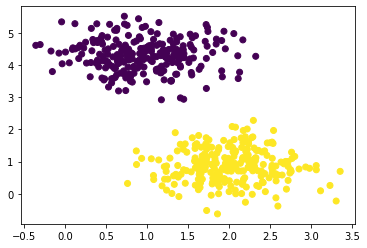

In [5]:
plt.scatter(X[:, 0], X[:, 1], c=y)

### Building a Linear Model

In [6]:
def predict(w, X):
  return jnp.dot(X, w)

In [7]:
def loss(w):
  preds = predict(w, X)
  return jnp.mean(jnp.clip(1 - jnp.multiply(y, preds), a_min=0))

In [8]:
np.random.seed(0)

w = np.random.randn(3)

### Gradient Descent with Automatic Differentiation

In [9]:
n_iters = 200
lr = 0.01
loss_grad = grad(loss)

losses = np.zeros(n_iters)
pbar = tqdm(range(n_iters))

for i in range(n_iters):
  grads = loss_grad(w)
  w = w - lr * grads

  tmp_loss = loss(w)
  losses[i] = tmp_loss

  pbar.set_postfix({'loss':tmp_loss})
  pbar.update()

  if tmp_loss == 0:
    break
pbar.close()

100%|██████████| 200/200 [00:02<00:00, 74.65it/s, loss=0.012640317] 


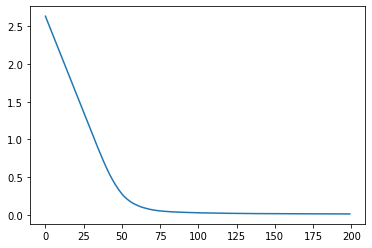

In [10]:
plt.plot(losses)

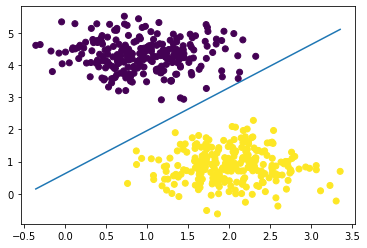

In [11]:
plt.scatter(X[:, 0], X[0:, 1], c=y)
xs = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
plt.plot(xs, (xs * w[0] + w[2]) / -w[1])

### Just-in-Time compilation for improved efficiency

In [12]:
np.random.seed(0)

w = np.random.randn(3)

In [14]:
n_iters = 200
lr = 0.01
loss_grad = jit(grad(loss))

losses = np.zeros(n_iters)
pbar = tqdm(range(n_iters))

for i in range(n_iters):
  grads = loss_grad(w)
  w = w - lr * grads

  tmp_loss = loss(w)
  losses[i] = tmp_loss
  
  pbar.set_postfix({'loss': tmp_loss})
  pbar.update()

  if tmp_loss == 0:
    break

pbar.close()

100%|██████████| 200/200 [00:00<00:00, 432.97it/s, loss=0.012640317]


### Automatic Vectorization for Efficient Kernels
#### Data that is not linearly separable

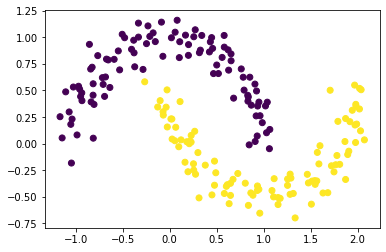

In [17]:
X, y = make_moons(n_samples=200, noise=0.1, random_state=0)
X = np.hstack((X, np.ones_like(y).reshape(-1, 1)))
y[y == 0] = -1

plt.scatter(X[:, 0], X[:, 1], c=y);

In [18]:
np.random.seed(0)

w = np.random.randn(3)

In [19]:
n_iters = 200
lr = 0.01
loss_grad = jit(grad(loss))

losses = np.zeros(n_iters)
pbar = tqdm(range(n_iters))

for i in range(n_iters):
  grads = loss_grad(w)
  w = w - lr * grads

  tmp_loss = loss(w)
  losses[i] = tmp_loss
  
  pbar.set_postfix({'loss': tmp_loss})
  pbar.update()

  if tmp_loss == 0:
    break

pbar.close()

100%|██████████| 200/200 [00:00<00:00, 357.08it/s, loss=0.70947087]


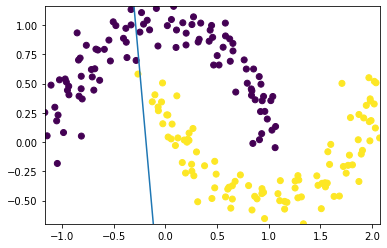

In [20]:
plt.scatter(X[:, 0], X[:, 1], c=y)

xs = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
plt.plot(xs, (xs * w[0] + w[2]) / w[1])

plt.xlim((X[:, 0].min(), X[:, 0].max()))
plt.ylim(X[:, 1].min(), X[:, 1].max());

### Kernelized SVM

In [21]:
def linear_kernel(x, z):
  return jnp.dot(x, z)

lengthscale = 0.3

def rbf_kernel(x, z):
  return jnp.exp(- jnp.linalg.norm(x - z) ** 2 / lengthscale)

def predict(alphas, X_test):
  return jnp.dot(vec_kernel(X, X_test), alphas)

def loss(alphas):
  preds = predict(alphas, X)
  return jnp.mean(jnp.clip(1 - jnp.multiply(y, preds), a_min=0))

In [22]:
kernel = rbf_kernel
vec_kernel = jit(vmap(vmap(kernel, (0, None)), (None, 0)))

np.random.seed(0)
alphas = np.random.randn(y.size)

In [23]:
n_iters = 200
lr = 0.01
loss_grad = jit(grad(loss))

losses = np.zeros(n_iters)
pbar = tqdm(range(n_iters))

for i in range(n_iters):
  grads = loss_grad(alphas)
  alphas = alphas - lr * grads

  tmp_loss = loss(alphas)
  losses[i] = tmp_loss
  
  pbar.set_postfix({'loss': tmp_loss})
  pbar.update()

  if tmp_loss == 0:
    break

pbar.close()

100%|██████████| 200/200 [00:01<00:00, 197.24it/s, loss=0.27256426]


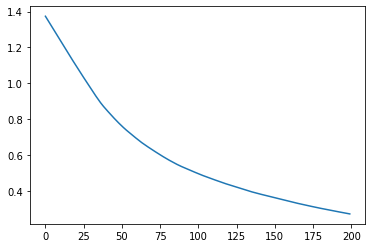

In [24]:
plt.plot(losses);

In [26]:
x_min = X[:, 0].min()
x_max = X[:, 0].max()
y_min = X[:, 1].min()
y_max = X[:, 1].max()

n_steps = 100

x_test_grid = np.linspace(x_min, x_max, n_steps)
y_test_grid = np.linspace(y_min, y_max, n_steps)

X1_test, X2_test = np.meshgrid(x_test_grid, y_test_grid, indexing = 'ij')
X_test = np.hstack((
    X1_test.reshape(-1, 1), 
    X2_test.reshape(-1, 1),
     np.ones((n_steps ** 2, 1))
     ))

preds = predict(alphas, X_test)

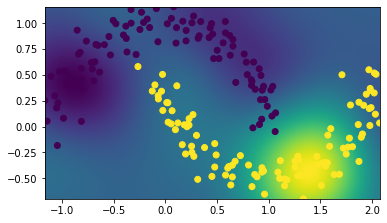

In [27]:
plt.imshow(
    preds.reshape(n_steps, n_steps).T,
    extent=[x_min, x_max, y_min, y_max],
    origin='lower'
)

plt.scatter(X[:, 0], X[:, 1], c=y);

### Non-JIT version for Comparison

In [28]:
kernel = rbf_kernel
vec_kernel = vmap(vmap(kernel, (0, None)), (None, 0))

np.random.seed(0)
alphas = np.random.randn(y.size)

In [29]:
n_iters = 200
lr = 0.01
loss_grad = grad(loss)

losses = np.zeros(n_iters)
pbar = tqdm(range(n_iters))

for i in range(n_iters):
  grads = loss_grad(alphas)
  alphas = alphas - lr * grads

  tmp_loss = loss(alphas)
  losses[i] = tmp_loss
  
  pbar.set_postfix({'loss': tmp_loss})
  pbar.update()

  if tmp_loss == 0:
    break

pbar.close()

100%|██████████| 200/200 [00:03<00:00, 57.04it/s, loss=0.27256426]
